In [20]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
import json
import math
from statsmodels.stats import diagnostic
from scipy import stats
from numpy.polynomial.polynomial import Polynomial

In [28]:
data_success = pd.read_csv('clean_data_success.csv')
data_character = pd.read_csv('clean_data_character.csv')
data_original = pd.read_csv('clean_data_original.csv')
ethnicity_df = pd.read_csv('ethnicity_labels.csv')

Based on this analysis, we can draft these two theories:

1. The Bechdel test results have improved over time, indicating a gradual shift towards more meaningful female representation in films.\
        Women were largely absent from lead roles in the early years of cinema, as reflected by the lower Bechdel test scores for films released before 1920.\
2. These conclusions highlight both the historical progression of women's roles in film and the evolving impact of the Bechdel test as a measure\
    of female representation in cinema.

## Bechdel Data Analysis

The Bechdel Test, or Bechdel-Wallace Test, sometimes called the Mo Movie Measure or Bechdel Rule is a simple test 
 which gives a score based on the following three criteria:
 1. it has to have at least two women in it
 2. They talk to each other
 3. They talk about something besides a man.

The test serves as a lens to evaluate whether a film provides meaningful interaction between female characters, reflecting broader trends in the portrayal of women in the film industry.

In this analysis, we will explore how Bechdel Test results have evolved over the years and across different regions of the world. We will also investigate how these scores relate to other aspects of films, such as revenue, ratings, and the presence of female lead actors.

By examining these relationships, our goal is to understand whether the representation of women in cinema has improved over time and whether films that perform well on the Bechdel Test are correlated with greater success. We aim to validate the theory that female representation is becoming more significant in the industry, potentially influencing a film's reception and success.

### Loading Bechdel dataset

The code below is used to get the Bechdel test results from the API and store them in a DataFrame

In [22]:
url = 'http://bechdeltest.com/api/v1/getAllMovies'

response = requests.get(url)

if response.status_code == 200:
    print('Request was succesful')
    movie_data = response.json()
    df_bechdel = pd.DataFrame(movie_data)
    print(df_bechdel.sample())

else:
    print('Request failed')

df_bechdel.rename(columns={'year':'Year'}, inplace= True)

Request was succesful
      year           title  rating    id   imdbid
3966  2000  102 Dalmatians       3  6002  0211181


### Bechdel test results along the years

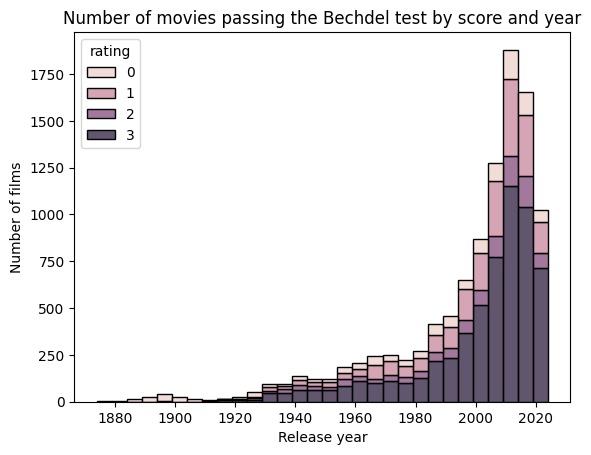

In [23]:
#we here want to plot the number of movies passing the Bechdel test by year and by score
sns.histplot(data=df_bechdel, x='Year', hue='rating',multiple='stack',bins=30)

plt.title('Number of movies passing the Bechdel test by score and year')
plt.xlabel('Release year')
plt.ylabel('Number of films');

We can see that the distribution of data along the years is heavily skewed. Therefore we will plot the proportion of each score among the years.

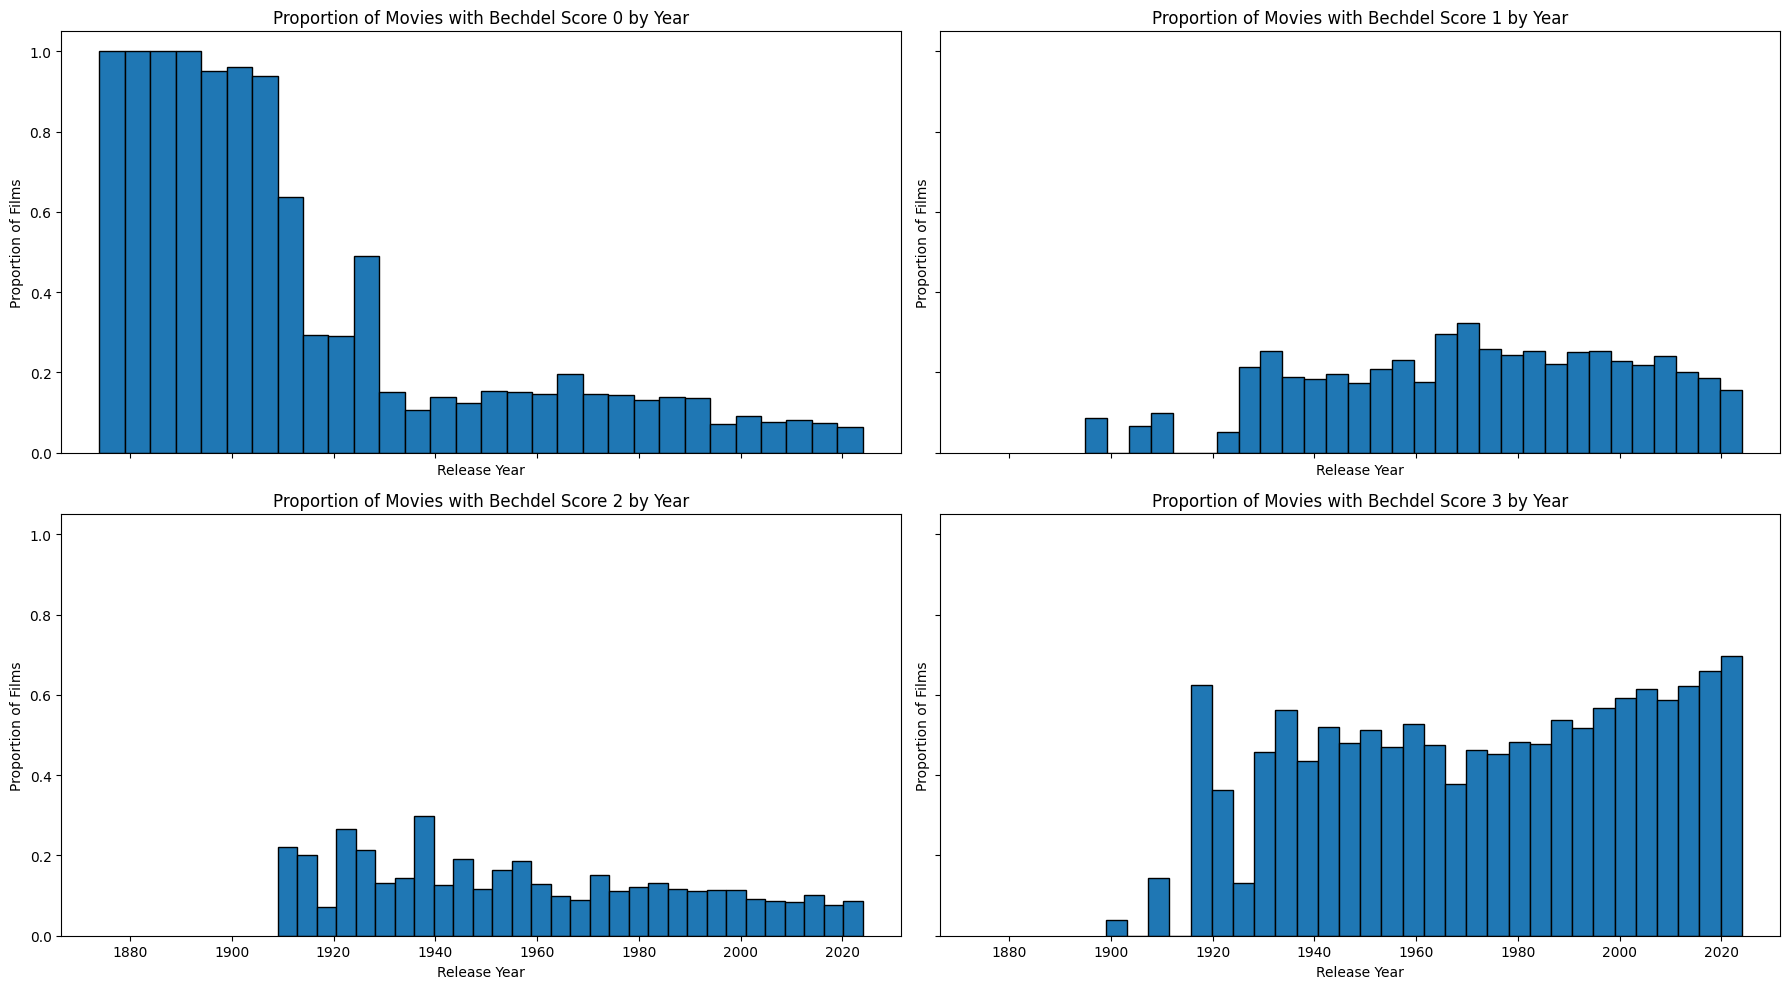

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the scores and titles
scores = [0, 1, 2, 3]
titles = [
    "Proportion of Movies with Bechdel Score 0 by Year",
    "Proportion of Movies with Bechdel Score 1 by Year",
    "Proportion of Movies with Bechdel Score 2 by Year",
    "Proportion of Movies with Bechdel Score 3 by Year"
]

fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True, sharey=True)

for i, (score, ax) in enumerate(zip(scores, axes.flatten())):
    # Filter the data for the current score
    filtered_data = df_bechdel.query(f'rating == {score}')
    
    # Create the histogram using numpy to calculate proportions
    counts, bin_edges = np.histogram(filtered_data['Year'], bins=30)
    bin_totals, _ = np.histogram(df_bechdel['Year'], bins=bin_edges)
    proportions = counts / bin_totals  # Normalize by total movies in each bin
    
    # Plot the normalized histogram
    ax.bar(bin_edges[:-1], proportions, width=np.diff(bin_edges), align='edge', edgecolor='black')
    ax.set_title(titles[i])
    ax.set_xlabel('Release Year')
    ax.set_ylabel('Proportion of Films')


plt.tight_layout()
plt.show()


By looking at the scale of the graphs, we can suppose that indeed we now have many more films passing the Bechdel test than failing it. However we have to considert the fact that the data is not equaly distributed along the years. Some proportions are not very representatives because there might not be enough data in the correspinding year. Hence we will only select the years for which we have a minimum of 20 movies.

To investigate this further, we will analyze the correlation between release years and the average Bechdel Test scores. Additionally, we will visualize the trend by plotting the average scores by year, supplemented with a linear regression line to highlight any patterns.

# Group by year and calculate total score and count of movies

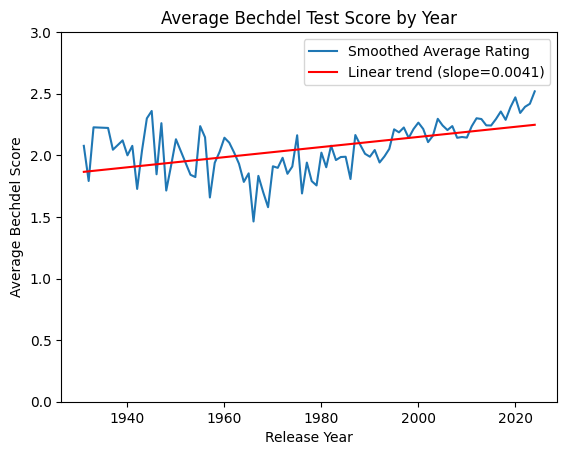

Pearson Correlation Coefficient: 0.5120, p-value: 2.92e-07, intercept: -6.06


In [25]:
# Group by year and calculate total score and count of movies
df_year_stats = df_bechdel.groupby('Year').agg(
    total_score=('rating', 'sum'),
    count=('rating', 'size')
).reset_index()


df_year_stats = df_year_stats[df_year_stats['count'] >= 20]
df_year_stats['avg_bechdel_score'] = df_year_stats['total_score'] / df_year_stats['count']

slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_stats['Year'], df_year_stats['avg_bechdel_score'])

sns.lineplot(data=df_year_stats, x='Year', y='avg_bechdel_score', label='Smoothed Average Rating')
plt.plot(df_year_stats['Year'], slope * df_year_stats['Year'] + intercept, color='red', label=f'Linear trend (slope={slope:.4f})')

plt.legend()
plt.title('Average Bechdel Test Score by Year')
plt.xlabel('Release Year')
plt.ylabel('Average Bechdel Score')

plt.ylim(0, 3)

plt.show()

print(f"Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue:.4g}, intercept: {intercept:.2f}")

Removing data where we have less than 20 movies we reduce our timeline from 1930 to 2024.

By these results, we can observe that the Bechdel test results definitely go up as the years go by. This can be interpreted from our positive slope and our negative intercept in the linear regression. Nevertheless our pearson correlation coefficent tells us that less than half of this increment is due to time passing by, and we should identify other impactful factors.

Lastly, we can affirm that this relationship is most probably not due to randomness, since our p-value is remarkably small.

### Bechdel Test Results in Different World Regions

To analyze how the Bechdel test results have evolved across various world regions, we opted to categorize the films by continent. This approach was chosen to avoid the complexities of geopolitical definitions. By utilizing the pycountry_convert library, we can efficiently convert countries into their respective continents.

For simplicity and based on the assumption that the first country listed in the data is the primary producer or responsible entity for the film, we decided to use only the first country in the list to determine the continent.

In [33]:
#Merging the bechdel dataset with the original datset containing movie
df_movies_bechdel = pd.merge(data_original, df_bechdel, how='inner', on=['title', 'Year'])

df_movies_bechdel['Countries'].value_counts()
df_movies_bechdel = df_movies_bechdel.rename(columns={'rating':'bechdel_score'})
df_movies_bechdel = df_movies_bechdel.drop(columns=['id']) 
df_movies_bechdel = df_movies_bechdel.drop_duplicates(['title','Wiki_ID'])

def get_continent(country_list):
    try:
        country_dict=json.loads(country_list)

        if not country_dict:
            return None

        country_name = list(country_dict.values())[0] #I might need to have different continents! Here I only have the first one!
        country_alpha2=pc.country_name_to_country_alpha2(country_name)
        return pc.country_alpha2_to_continent_code(country_alpha2)
    except KeyError or IndexError:
        return None

df_movies_bechdel['continent']=df_movies_bechdel['Countries'].apply(get_continent)

df_movies_bechdel['continent'].value_counts()

continent
NA    2987
EU     612
AS     186
OC      40
SA       5
AF       2
Name: count, dtype: int64

There is a noticeable underrepresentation of non-North American and non-European films in the Bechdel test database. This disparity can be attributed to the test's popularity being primarily concentrated in North America, with limited focus on international films in the analysis.

For clarity and a more focused visualization, we will restrict the plots to films from North America, Europe, and Asia.

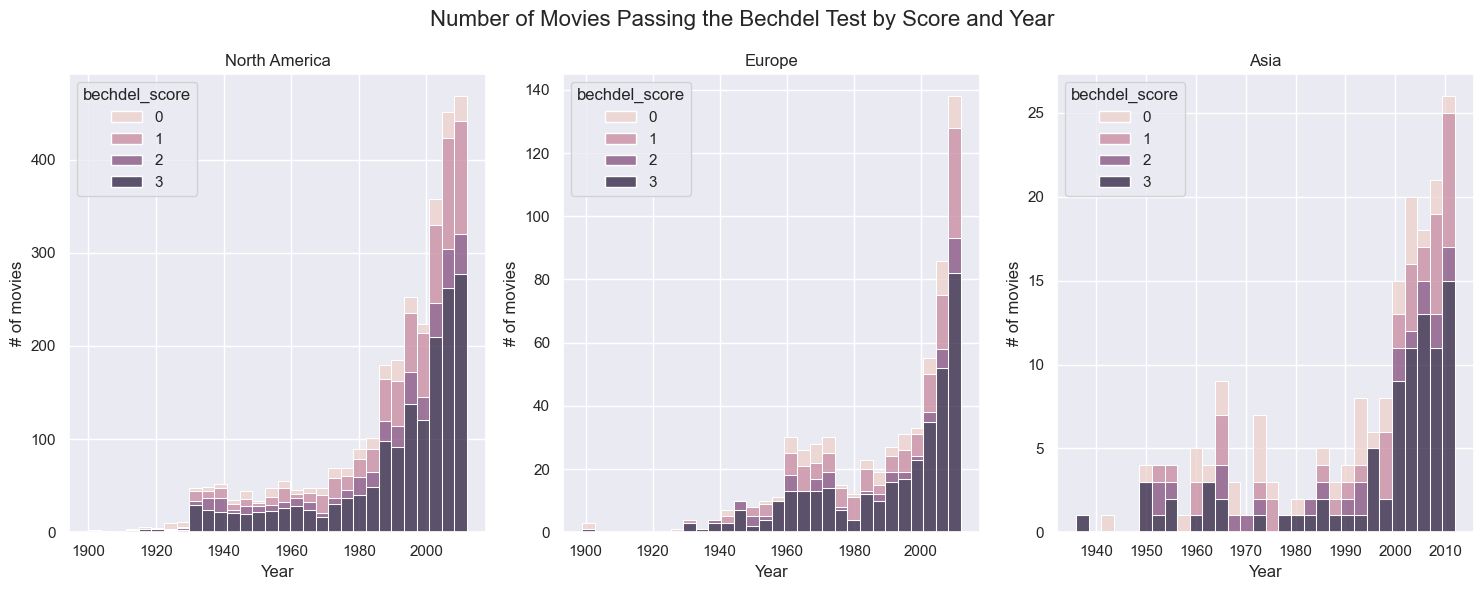

In [34]:
sns.set()

fig, axes = plt.subplots(1,3, figsize = (15,6))

fig.suptitle('Number of Movies Passing the Bechdel Test by Score and Year', fontsize=16)

sns.histplot(data=df_movies_bechdel[df_movies_bechdel['continent'] == 'NA'], x='Year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[0]).set(title='North America', 
                                                                                                                          ylabel = '# of movies')
sns.histplot(data=df_movies_bechdel[df_movies_bechdel['continent'] == 'EU'], x='Year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[1]).set(title='Europe', 
                                                                                                                          ylabel = '# of movies')
sns.histplot(data=df_movies_bechdel[df_movies_bechdel['continent'] == 'AS'], x='Year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[2]).set(title='Asia', 
                                                                                                                          ylabel = '# of movies')

plt.tight_layout();

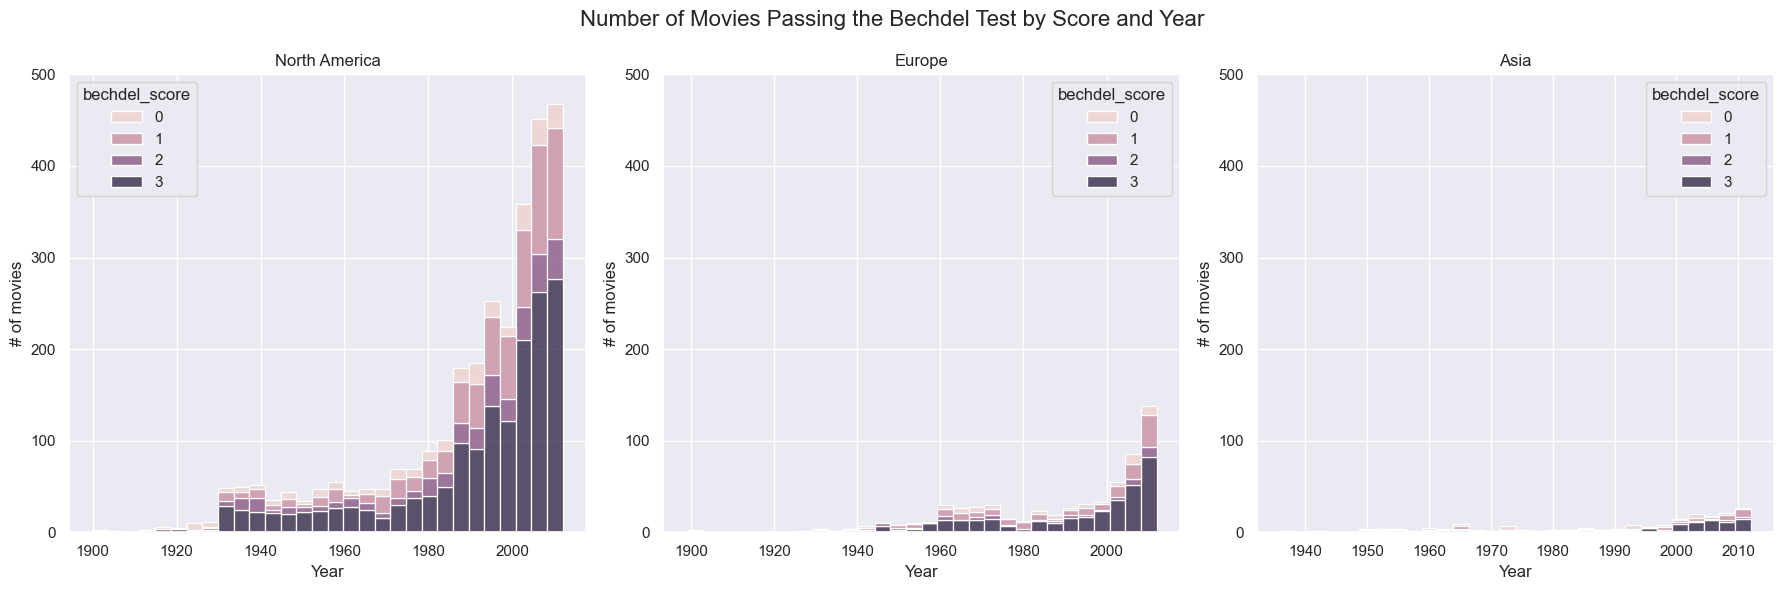

In [42]:
sns.set()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Number of Movies Passing the Bechdel Test by Score and Year', fontsize=16)

# North America
sns.histplot(
    data=df_movies_bechdel[df_movies_bechdel['continent'] == 'NA'],
    x='Year',
    hue='bechdel_score',
    multiple='stack',
    bins=30,
    ax=axes[0]
).set(title='North America', ylabel='# of movies')
axes[0].set_ylim(0, 500)

# Europe
sns.histplot(
    data=df_movies_bechdel[df_movies_bechdel['continent'] == 'EU'],
    x='Year',
    hue='bechdel_score',
    multiple='stack',
    bins=30,
    ax=axes[1]
).set(title='Europe', ylabel='# of movies')
axes[1].set_ylim(0, 500)

# Asia
sns.histplot(
    data=df_movies_bechdel[df_movies_bechdel['continent'] == 'AS'],
    x='Year',
    hue='bechdel_score',
    multiple='stack',
    bins=30,
    ax=axes[2]
).set(title='Asia', ylabel='# of movies')
axes[2].set_ylim(0, 500)

plt.tight_layout()
plt.show()


We are unable to perform a linear regression for Europe nor Asia  because we are lacking too many data.